<div style="text-align:center;">
    <img src="http://www.cs.wm.edu/~rml/images/wm_horizontal_single_line_full_color.png">
    <h1>CSCI 416-01/516-01, Fall 2024</h1>
    <h1>Building a classifier for the 2016 presidential election</h1>
</div>

SAMMY MARTINEZ

# Contents
* [The problem](#The-problem)
* [The data](#The-data)
* [To do](#To-do)
* [What to submit](#What-to-submit)

# The problem

In this problem you will look at county-level data for the 2016 presidential election ("county" is used loosely here, e.g., Virginia has independent cities that are included as counties).

The goal is to build a classifier to determine whether a county voted for Hilary Clinton or for Donald Trump.

The demographic and geographic features for each county are listed below.

An interesting feature of the election is the so-called [Clinton Archipelago](https://vividmaps.com/trumpland-and-clinton-archipelago): Clinton carried relatively few counties compared to Trump (but they were counties with large populations):
<pre>
County breakdown:  your data  my test set    total
         Clinton         330          158      488
         Trump          1670          954     2624
       
</pre>

The simplest classifier we can build from the training data would be to say all counties vote Trump.  This classifier would be correct for  
$$
  1 - \frac{330}{330 + 1670} = 83.5\%
$$
of the data you are provided, and
$$
1 - \frac{158}{158 + 954} = 85.8\%
$$
of my test cases!  So whatever classifier you build must be substantially better than the majority class classifier.

# The data

The data you have to work with are in [<code>vote16_classification.csv</code>](http://www.cs.wm.edu/~rml/teaching/csci416/midterm/vote16_classification.csv).  This is a CSV file.

Column 0 is the class label:
<pre>
0: won by Clinton
1: won by Trump
</pre>

The next column is
<pre>
state_abbr:  the state's abbreviation
</pre>

These are followed by information about the 2012 election, including the proportion voting for Obama and Romney as well as the vote totals themselves:
<pre>
total_votes_2012: total number of votes cast in the 2012 election
votes_dem_2012:   number of votes cast for the Democratic candidate in 2012
votes_rep_2012:   number of votes cast for the Republican candidate in 2012
Obama:            percentage voting for Obama in 2012
Romney:           percentage voting for Romney in 2012
</pre>

The remaining columns are demographic data about the geographical unit:
<pre>
PST045214: Population, 2014 estimate
PST040210: Population, 2010 (April 1) estimates base
PST120214: Population, percent change - April 1, 2010 to July 1, 2014
POP010210: Population, 2010
AGE135214: Persons under 5 years, percent, 2014
AGE295214: Persons under 18 years, percent, 2014
AGE775214: Persons 65 years and over, percent, 2014
SEX255214: Female persons, percent, 2014
RHI125214: White alone, percent, 2014
RHI225214: Black or African American alone, percent, 2014
RHI325214: American Indian and Alaska Native alone, percent, 2014
RHI425214: Asian alone, percent, 2014
RHI525214: Native Hawaiian and Other Pacific Islander alone, percent, 2014
RHI625214: Two or More Races, percent, 2014
RHI725214: Hispanic or Latino, percent, 2014
RHI825214: White alone, not Hispanic or Latino, percent, 2014
POP715213: Living in same house 1 year & over, percent, 2009-2013
POP645213: Foreign born persons, percent, 2009-2013
POP815213: Language other than English spoken at home, pct age 5+, 2009-2013
EDU635213: High school graduate or higher, percent of persons age 25+, 2009-2013
EDU685213: Bachelor's degree or higher, percent of persons age 25+, 2009-2013
VET605213: Veterans, 2009-2013
LFE305213: Mean travel time to work (minutes), workers age 16+, 2009-2013
HSG010214: Housing units, 2014
HSG445213: Homeownership rate, 2009-2013
HSG096213: Housing units in multi-unit structures, percent, 2009-2013
HSG495213: Median value of owner-occupied housing units, 2009-2013
HSD410213: Households, 2009-2013
HSD310213: Persons per household, 2009-2013
INC910213: Per capita money income in past 12 months (2013 dollars), 2009-2013
INC110213: Median household income, 2009-2013
PVY020213: Persons below poverty level, percent, 2009-2013
BZA010213: Private nonfarm establishments, 2013
BZA110213: Private nonfarm employment,  2013
BZA115213: Private nonfarm employment, percent change, 2012-2013
NES010213: Nonemployer establishments, 2013
SBO001207: Total number of firms, 2007
SBO315207: Black-owned firms, percent, 2007
SBO115207: American Indian- and Alaska Native-owned firms, percent, 2007
SBO215207: Asian-owned firms, percent, 2007
SBO515207: Native Hawaiian- and Other Pacific Islander-owned firms, percent, 2007
SBO415207: Hispanic-owned firms, percent, 2007
SBO015207: Women-owned firms, percent, 2007
MAN450207: Manufacturers shipments, 2007 ($1,000)
WTN220207: Merchant wholesaler sales, 2007 ($1,000)
RTN130207: Retail sales, 2007 ($1,000)
RTN131207: Retail sales per capita, 2007
AFN120207: Accommodation and food services sales, 2007 ($1,000)
BPS030214: Building permits, 2014
LND110210: Land area in square miles, 2010
POP060210: Population per square mile, 2010
</pre>

In [1]:
# Load the data.

import pandas as pd
import numpy  as np

print('Reading the data...', end='')
df = pd.read_csv('vote16_classification.csv')
print('done!')

y = df.iloc[:,0]
X = df.iloc[:,1:]

X.head()

Reading the data...done!


,state_abbr,total_votes_2012,votes_dem_2012,votes_gop_2012,Obama,Romney,PST045214,PST040210,PST120214,POP010210,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,IA,4804,2369,2373,0.493131,0.493963,9200,9337,-1.5,9336,...,0.0,23.1,0,144862,87923,9258,3859,6,569.57,16.4
1,GA,7757,1499,6112,0.193245,0.787933,22264,22084,0.8,22084,...,0.0,25.3,430397,107788,315062,14431,22760,2,261.50,84.5
2,NC,50353,18115,31695,0.359760,0.629456,187589,177772,5.5,177772,...,0.0,29.0,253035,96946,1913882,11698,287943,1081,762.74,233.1
3,TX,813,109,700,0.134071,0.861009,1608,1641,-2.0,1641,...,0.0,0.0,0,3416,6813,4195,0,0,912.55,1.8
4,KS,4955,1393,3495,0.281130,0.705348,23465,22952,2.2,22952,...,0.0,19.2,0,197478,314598,13898,32249,62,639.50,35.9


You will need to decide how to handle the state abbreviation, which is a categorical variable.  Solutions include
* one-hot encoding,
* categorical encoding, and
* dropping this feature from the data.

Whatever you do should be incorporated in your classification pipeline so I can reproduce your results on my test data.

The First step for this project was determining which classifier would work best. For this step, I decided to try them all, and with the comments in the code below my results may be observed. The biggest takeaway from the results was that because RandomForests performed the best, and it had more hyperparameters, it seemed like a natural fit for my classifier of choice. Through minor changes, I figured it would be easy to squeeze more accuracy out of this classifier. 

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
# Load the data
data = pd.read_csv('vote16_classification.csv')  # Replace with your actual data file

# Define features and target
X = data.drop(columns=['label'])  # Replace 'vote' with your actual target column name
y = data['label']  # Assuming 'vote' is 0 for Clinton and 1 for Trump

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#'num' transformer: fills in missing values with SimpleImputer
# 'cat' Deals with categorical feature, 'state_abbr', using OneHotEncoder
# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), X.select_dtypes(include=['object']).columns)
    ]
)

# Random Forest:
# SVM - took WAY too long to train
# decision trees - .965
# Linear Discriminant  Analysis - .955
# quadratic discriminant Analysis - .925
# logistic regression - .95
# random forests - .9675, n_estimators = 200, random_state = 39
# k nearest Neighbors - .85 horrible
#decision OR random Forests
#decision
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    #('scaler', StandardScaler()), Scaling is NOT necessary for Trees!
    ('classifier', RandomForestClassifier(n_estimators=200,random_state=39))

])

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

#Saving model
import joblib
joblib.dump(pipeline, 'random_forest_voting_model.pkl')
print('Model saved as random_forest_voting_model.pkl')
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())


C:\Users\Sammy Martinez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy: 0.97
Confusion Matrix:
 [[ 67   9]
 [  3 321]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.88      0.92        76
         1.0       0.97      0.99      0.98       324

    accuracy                           0.97       400
   macro avg       0.96      0.94      0.95       400
weighted avg       0.97      0.97      0.97       400

Model saved as random_forest_voting_model.pkl


C:\Users\Sammy Martinez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Cross-validation scores: [0.9625 0.9725 0.965  0.97   0.975 ]
Mean cross-validation score: 0.969


# To do

* Build a classifier that predicts how a county votes with at least 98% overall accuracy.  It isn't too difficult to obtain 98% overall accuracy, and at least 95% accuracy for each candidate.  More accurate is better for this problem.
* Populate this Jupyter notebook with the code needed to create, train, and run your classifier.
    * As part of your model evaluation, your notebook should compute and print the confusion matrix and other measures of accuracy.
    * The notebook will also serve for you to include a discussion of what you did.
        - What classifiers did you try?  
        - What tuning did you do?
        - How did the classifiers perform?  You might want to look at [this discussion of model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html) in Scikit-Learn.
        - How did you settle on your final choice of classifier?
        - Do you have any sense of what the classifier is doing?  e.g., what are the most important features?
* You should build your classifier and any preprocessing as a scikit-learn <code>Pipeline</code>.
* You should save your classification pipeline to the file <code>vote16_clf.pkl</code> using <code>sklearn.externals.joblib</code> (see below).
* If you use a grid search or random search for hyperparameter tuning, you should indicate this in the write-up below, and submit the hyperparameters used in the submitted solution (you can just specify them in calls to the classifier's constructor).
* If you try a classifier and it does not work to your liking, you should indicate this.  You can leave the code in the notebook, commented out, so I can see what you tried.

* You can choose from any of the classifiers we have studied (other than neural networks), including
 - [k nearest neighbors](http://scikit-learn.org/stable/modules/neighbors.html),
 - [support vector machines / kernel machines](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html),
 - [decision trees](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier),
 - [Linear discriminant analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)
 -  [quadratic discriminant analysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)
 - [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html),
 - [support vector and kernel classifiers](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
 - ensembles of the preceding (e.g., [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and [AdaBoosted collections of weak learners](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)),
 
## Note

In order to build a pipeline you will may need to implement your own first step of the pipeline in order to perform feature selection and any necessary feature encoding.  You can do so by creating your own class with a <code>fit()</code> and <code>transform()</code> method.  

The calling sequences and return sequences of these two methods should be the same as those of the StandardScaler [<code>fit()</code>](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.fit) and [<code>transform()</code>](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler.transform).

For example, <code>fit()</code> might not do anything while <code>transform()</code> will return a subset of the variables as a numpy array.

For full credit your pipeline should encapsulate all of your preprocessing steps.  If you cannot figure out how to make this work, you can enter your preprocessing steps below.

# What to submit

1. This Jupyter notebook, filled out with code that when run will produce a working classifer with all necessary preprocessing.
    * You should use your final hyperparameter values in the call to the classifier's constructor.
2. If you get the pipeline working, the resulting <code>.pkl</code> file as follows.

C:\Users\Sammy Martinez\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy: 0.98
Confusion Matrix:
 [[ 74   2]
 [  6 318]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95        76
         1.0       0.99      0.98      0.99       324

    accuracy                           0.98       400
   macro avg       0.96      0.98      0.97       400
weighted avg       0.98      0.98      0.98       400



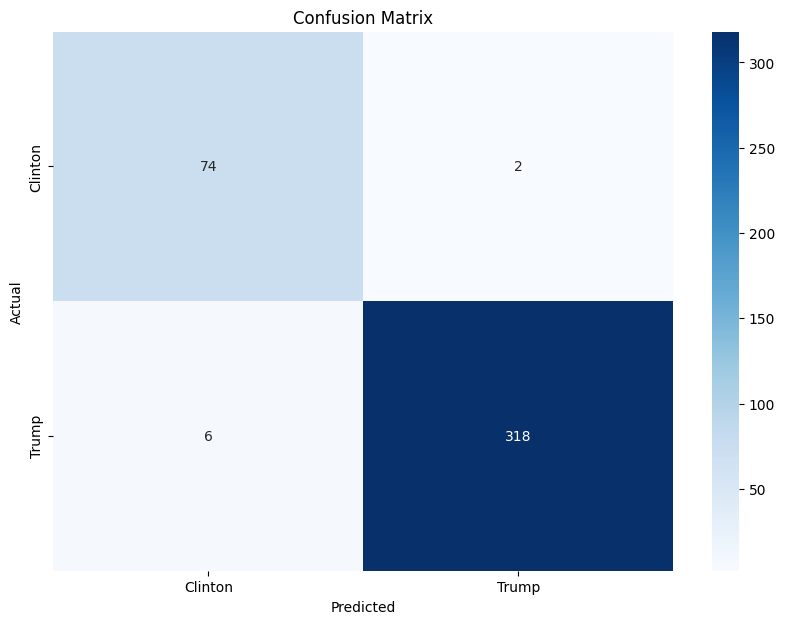

Saving the classifier...


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.over_sampling import SMOTE

# Load the data
data = pd.read_csv('vote16_classification.csv')  # Replace with your actual data file

# Define features and target
#X = data.drop(columns=['label'])  # Replace 'label' with your actual target column name
#X = data.drop(columns=['label'])
#X=data
X = data.drop(columns=['label'])

y = data['label']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Unable to get to work
class Drop_Column_2(BaseEstimator,TransformerMixin):
    def fit(self, X=None, y=None, sample_weight=None):
        return self

    def transform(self, X, copy=None):
          return X.iloc[:, 1:] 
class Drop_Column_1(BaseEstimator,TransformerMixin):
    def fit(self, X=None, y=None, sample_weight=None):
        return self

    def transform(self, X, copy=None):
        return X.iloc[:,1:]
    
# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        #('drop', Drop_Column_1(), X.columns),
        ('number_editing', SimpleImputer(strategy='mean'), X.select_dtypes(include=['int64', 'float64']).columns),
        ('categorical_Data', OneHotEncoder(drop='first', handle_unknown='ignore'), X.select_dtypes(include=['object']).columns)
    ]
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

#Preprocessing
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Smote 
smote = SMOTE(random_state=100)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

 #Training model
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=39)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = rf_classifier.predict(X_test_processed)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

import joblib
import matplotlib.pyplot as plt
import seaborn as sns
#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clinton', 'Trump'], yticklabels=['Clinton', 'Trump'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#Saving classifier
import dill
print('Saving the classifier...')
with open('vote16_classifier.dill', 'wb') as file:
    dill.dump(rf_classifier, file)
with open('vote16_classifier.dill', 'rb') as file:
    loaded_rf_classifier = dill.load(file)

To squeeze more accuracy out of the model, I applited the SMOTE algorithm. As stated in this project description, there is a class inbalance between the counties who voted Clinton, and the counties who voted for Trump. SMOTE creates artificial members of the lower class to pad the data and to make the model more immune to class inbalances. In the case of the RandomForest classifier, I found that it was able to squeeze more performance out of the model. 

Class inbalance is an integral aspect of classifiers, as rudimentary algorithms will give fantastic results!...given that the majority class is an easy guess with a 9:1 ratio. Algorithms that deal with class inbalance may be particularly useful for such skewed datasets. 

Note about the pipeline: Unable to combine certain steps with the pipeline. Steps not included in the pipeline: dropping the first column, splitting the data, applying the SMOTE algorithm. The SMOTE algorithm requires 2 parameters, and I was unable to get this to work. 